<a href="https://colab.research.google.com/github/PauDK/Deceptive-Review-Detection/blob/main/BERT_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 20.4 MB/s 
     |████████████████████████████████| 588.3 MB 6.3 kB/s 
     |████████████████████████████████| 1.7 MB 53.4 MB/s 
     |████████████████████████████████| 439 kB 74.0 MB/s 
     |████████████████████████████████| 6.0 MB 53.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/fake-review-detection/src/common/')

In [4]:
import data_preprocessing
import os

root_dir = "/content/drive/My Drive/Colab Notebooks/fake-review-detection/data"
df = data_preprocessing.import_raw_data(root_dir)
display(df[:5])

df.to_csv(os.path.join(root_dir, 'labeled-data/Chicago_Hotel_Reviews.csv'))

,Label,Rating,Ori_Review
0,1,1,The Fairmont Chicago Millennium Park has to be...
1,1,1,Me and my business associate had a job in Chic...
2,1,1,I stayed with my husband at the Homewood Suite...
3,1,1,My wife and I went to Chicago to enjoy our wee...
4,1,1,I recently stayed at the Hyatt Regency in Chic...


In [110]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from matplotlib import pyplot as plt
from tensorflow import keras
from official.nlp import optimization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [79]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/fake-review-detection/data/labeled-data/Chicago_Hotel_Reviews.csv", index_col=0)
df = df.drop('Rating', axis=1)
df.loc[df['Label'] == -1, 'Label'] = 0
X = df['Ori_Review']
y = df['Label']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [81]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [82]:
text_inputs = [keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

seq_length = 512  # Set sequence length
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))
preprocessed_text = bert_pack_inputs(tokenized_inputs)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1b336f2f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1b336f8a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1b336f2a10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1b336ff4d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1b336ff9d0>],
 'means': []}

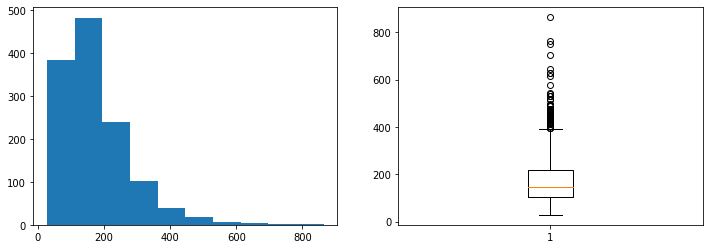

In [83]:
sizes = []
tokens = tokenize(X_train)
for i in range(tokens.shape[0]):
  sizes.append(tokens[i].shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.hist(sizes)
ax2.boxplot(sizes)

In [84]:
text_inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'input_3')>]

In [85]:
preprocessed_text

{'input_type_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_7')>,
 'input_word_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_7')>,
 'input_mask': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_7')>}

In [86]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [87]:
# Train all BERT layers as suggested by BERT developers
bert_encoder.trainable = True

# Bert layers
outputs = bert_encoder(preprocessed_text)

# Dense layers
l = keras.layers.Dense(1, activation='sigmoid', name="output") (outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = keras.Model(inputs=text_inputs, outputs = [l])

In [88]:
epochs = 3
batch_size = 8
init_lr = 3e-5  # best of [5e-5, 3e-5, 2e-5]

train_data_size = X_train.shape[0]
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

test_data_size = X_test.shape[0]

In [89]:
optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='accuracy')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     (None, None, None)   0           ['input_3[0][0]']                
                                                                                                  
 keras_layer_7 (KerasLayer)     {'input_type_ids':   0           ['keras_layer_6[0][0]']          
                                (None, 512),                                                      
                                 'input_word_ids':                                                
                                (None, 512),                                                

In [90]:
bert_encoder.trainable = False
model.fit(X_train,
          y_train,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=(X_test, y_test))

Epoch 1/3
160/160 [==============================] - 196s 1s/step - loss: 0.4991 - accuracy: 0.7547 - val_loss: 0.3450 - val_accuracy: 0.8656
Epoch 2/3
160/160 [==============================] - 178s 1s/step - loss: 0.2853 - accuracy: 0.9031 - val_loss: 0.4296 - val_accuracy: 0.8844
Epoch 3/3
160/160 [==============================] - 171s 1s/step - loss: 0.1140 - accuracy: 0.9672 - val_loss: 0.4488 - val_accuracy: 0.9000


In [107]:
prediction = model.predict(X_test)
prediction_real = model.predict(X_test[y_test == 0])
prediction_fake = model.predict(X_test[y_test == 1])

5/5 [==============================] - 5s 1s/step


In [104]:
# Manual calculation of Model Performance parameters
true_negative = 0
false_positive = 0
for val in prediction_real:
  if val <= 0.5:
    true_negative+=1
  else:
    false_positive+=1

true_positive = 0
false_negative = 0
for val in prediction_fake:
  if val > 0.5:
    true_positive+=1
  else:
    false_negative+=1

accuracy_score = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
precision_score = true_positive/(true_positive + false_positive)
recall_score = true_positive/(true_positive + false_negative)
f1_score = 2 * precision_score * recall_score /(precision_score + recall_score)

print('BERT Model Performance:')
# print(f'True Positive: {true_positive}')
# print(f'True Negative: {true_negative}')
# print(f'False Positive: {false_positive}')
# print(f'False Negative: {false_negative}')
print('Accuracy: ' + '{:.2%}'.format(accuracy_score))
print('Precision: ' + '{:.2%}'.format(precision_score))
print('Recall: ' + '{:.2%}'.format(recall_score))
print('F1 Score: ' + '{:.2%}'.format(f1_score))

Bert Model Performance:
Accuracy: 90.00%
Precision: 83.98%
Recall: 98.06%
F1 Score: 90.48%


In [113]:
# Calculation of Model Performance parameters using sklearn library
y_pred = prediction.copy()
y_pred[prediction <= 0.5] = 0
y_pred[prediction > 0.5] = 1

print('BERT Model Performance:')
print('- Test Accuracy: ', "{:.1%}".format(accuracy_score(y_test, y_pred)))
print('- Test Precision Score: ', "{:.1%}".format(precision_score(y_test, y_pred)))
print('- Test Recall Score: ', "{:.1%}".format(recall_score(y_test, y_pred)))
print('- Test F1 Score: ', "{:.1%}".format(f1_score(y_test, y_pred)))
print('- Test AUC-ROC Score: ', "{:.1%}".format(roc_auc_score(y_test, y_pred)))

BERT Model Performance:
- Test Accuracy:  90.0%
- Test Precision Score:  84.0%
- Test Recall Score:  98.1%
- Test F1 Score:  90.5%
- Test AUC-ROC Score:  90.2%


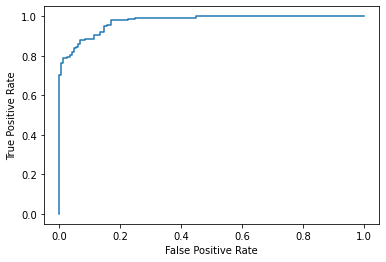

In [111]:
y_test_labels = np.array(y_test)

fpr, tpr, _ = roc_curve(y_test_labels, prediction)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
demo_ind = np.random.choice(X_test.index)
realfake = 'Real' if y_test[demo_ind] == 0 else 'Fake'
prediction = model.predict([X_test[demo_ind]])
prediction_rf = 'Real' if prediction <= 0.5 else 'Fake'

print(f'{realfake} review to be fed to model:\n', X_test[demo_ind], '\n')
print(f'Model prediction: {prediction_rf}')

1/1 [==============================] - 0s 42ms/step
Fake review to be fed to model:
 The Hyatt Regency in Chicago was a wonderful experience for my husband and I as we traveled through the area on vacation. After checking in we simply relaxed in the beautiful atrium for a while before going to our room. To our delight the room was very clean, ultra-modern and furnished with sleek and comfortable furniture. What really impressed us about the room was how spacious it was and the stunning river front views. We were pressed for time to make dinner so decided the Bistro sounded like the best option and it turned out to be a great choice! The food was simply fabulous. After dinner we were able to try out the fitness center, which ended up making our gym at home seem inadequate. This was just what we needed as a restful base for our Chicago vacation and we will definitely stay here again. 

Model prediction: Fake


In [95]:
main_save_path = '/content/drive/My Drive/Colab Notebooks/fake-review-detection/models'
saved_model_name = 'Fine_Tune_Bert_Accu_final_1'
saved_model_path = os.path.join(main_save_path, saved_model_name)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

model.save(saved_model_path, include_optimizer=False, options=save_options)